<a href="https://colab.research.google.com/github/realfolkcode/GraphRegression/blob/master/label_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Install

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!git clone https://github.com/realfolkcode/GraphRegression.git

Cloning into 'GraphRegression'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 128 (delta 46), reused 90 (delta 25), pack-reused 0
Receiving objects: 100% (128/128), 302.33 KiB | 287.00 KiB/s, done.
Resolving deltas: 100% (46/46), done.


In [3]:
from GraphRegression.utils import load_jj_data, set_random_seeds

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 0

# Process Data

In [5]:
path = "GraphRegression/data/county/election/2012"
adj, X, y, idx_train, idx_val, idx_test = load_jj_data(path)
y = y.reshape(-1, 1)

print("adj:", adj.shape)
print("features:", X.shape)
print("labels:", y.shape)
print("idx_train:", idx_train.shape)
print("idx_val:", idx_val.shape)
print("idx_test:", idx_test.shape)

adj: torch.Size([3234, 3234])
features: torch.Size([3234, 6])
labels: torch.Size([3234, 1])
idx_train: torch.Size([1941])
idx_val: torch.Size([646])
idx_test: torch.Size([647])


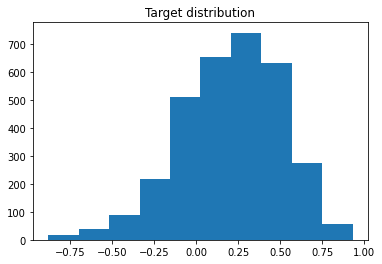

In [6]:
plt.hist(y.flatten())
plt.title('Target distribution')
plt.show()

# MLP

In [7]:
class MLP(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(n_in, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
        )
        self.regressor = nn.Linear(16, 1)
    
    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

In [11]:
def epoch_train(model, loader, criterion, opt):
    train_loss = 0
    model.train()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
    train_loss /= len(loader)
    return train_loss

In [12]:
def epoch_val(model, loader, criterion):
    val_loss = 0
    target_lst = []
    output_lst = []
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            target_lst += target.tolist()
            output_lst += output.tolist()
            val_loss = criterion(output, target).item()
    r2 = r2_score(target_lst, output_lst)
    val_loss /= len(loader)
    return val_loss, r2

In [36]:
set_random_seeds(seed_value=RANDOM_SEED, device=device)

mlp = MLP(6).to(device)

In [37]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(mlp.parameters())

In [38]:
batch_size = 128

train_loader = DataLoader(TensorDataset(X[idx_train], y[idx_train]), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X[idx_val], y[idx_val]), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X[idx_test], y[idx_test]), batch_size=batch_size, shuffle=False)

In [39]:
num_epochs = 75

train_loss = []
val_loss = []
val_r2 = []
test_loss = []
test_r2 = []

for i in tqdm(range(num_epochs)):
    loss = epoch_train(mlp, train_loader, criterion, opt)
    train_loss.append(np.sqrt(loss))

    loss, r2 = epoch_val(mlp, val_loader, criterion)
    val_loss.append(np.sqrt(loss))
    val_r2.append(r2)

    loss, r2 = epoch_val(mlp, test_loader, criterion)
    test_loss.append(np.sqrt(loss))
    test_r2.append(r2)
    print('---------------------------------------------------------')
    print(f'Epoch: {i}, Val R2: {val_r2[-1]}, Test R2: {test_r2[-1]}')

  3%|▎         | 2/75 [00:00<00:05, 14.59it/s]

---------------------------------------------------------
Epoch: 0, Val R2: -0.002688274325015172, Test R2: 0.045387936383149086
---------------------------------------------------------
Epoch: 1, Val R2: 0.094400171534195, Test R2: 0.14554112816768894
---------------------------------------------------------
Epoch: 2, Val R2: 0.1556305820665752, Test R2: 0.2005662957161123


  8%|▊         | 6/75 [00:00<00:05, 13.16it/s]

---------------------------------------------------------
Epoch: 3, Val R2: 0.20069958602537075, Test R2: 0.24136633144980768
---------------------------------------------------------
Epoch: 4, Val R2: 0.2291284302044363, Test R2: 0.262531413486765
---------------------------------------------------------
Epoch: 5, Val R2: 0.25388043716797337, Test R2: 0.2794290894069783


 11%|█         | 8/75 [00:00<00:05, 13.21it/s]

---------------------------------------------------------
Epoch: 6, Val R2: 0.2676683807085366, Test R2: 0.2903053297987842
---------------------------------------------------------
Epoch: 7, Val R2: 0.2813743717562649, Test R2: 0.2946627199247738
---------------------------------------------------------
Epoch: 8, Val R2: 0.2887310838310837, Test R2: 0.2989290459296883


 16%|█▌        | 12/75 [00:00<00:04, 13.62it/s]

---------------------------------------------------------
Epoch: 9, Val R2: 0.2937925660566497, Test R2: 0.3023981116461234
---------------------------------------------------------
Epoch: 10, Val R2: 0.29770633292867166, Test R2: 0.3037185668406335
---------------------------------------------------------
Epoch: 11, Val R2: 0.30190181286840256, Test R2: 0.30707818938166753


 19%|█▊        | 14/75 [00:01<00:04, 13.52it/s]

---------------------------------------------------------
Epoch: 12, Val R2: 0.3126500582726155, Test R2: 0.3160453880118582
---------------------------------------------------------
Epoch: 13, Val R2: 0.31258470713808806, Test R2: 0.3129952585912795
---------------------------------------------------------
Epoch: 14, Val R2: 0.31851204912564257, Test R2: 0.3220454982758092


 24%|██▍       | 18/75 [00:01<00:04, 13.76it/s]

---------------------------------------------------------
Epoch: 15, Val R2: 0.3230206204226139, Test R2: 0.32724516697950623
---------------------------------------------------------
Epoch: 16, Val R2: 0.32491928530414993, Test R2: 0.32825518943706866
---------------------------------------------------------
Epoch: 17, Val R2: 0.3277357483431491, Test R2: 0.3303355999445592


 27%|██▋       | 20/75 [00:01<00:04, 13.45it/s]

---------------------------------------------------------
Epoch: 18, Val R2: 0.3309782459607815, Test R2: 0.3310277217082681
---------------------------------------------------------
Epoch: 19, Val R2: 0.3366804972728822, Test R2: 0.3368394688604863
---------------------------------------------------------
Epoch: 20, Val R2: 0.33678527527312463, Test R2: 0.3314998791779795


 32%|███▏      | 24/75 [00:01<00:03, 13.59it/s]

---------------------------------------------------------
Epoch: 21, Val R2: 0.33990876284756333, Test R2: 0.3369607535206709
---------------------------------------------------------
Epoch: 22, Val R2: 0.3450030042114739, Test R2: 0.3448767962535385
---------------------------------------------------------
Epoch: 23, Val R2: 0.3447202237033393, Test R2: 0.3424851812980305


 35%|███▍      | 26/75 [00:01<00:03, 13.65it/s]

---------------------------------------------------------
Epoch: 24, Val R2: 0.3510103457519972, Test R2: 0.34777774342559675
---------------------------------------------------------
Epoch: 25, Val R2: 0.3517254602161798, Test R2: 0.34879655291211475
---------------------------------------------------------
Epoch: 26, Val R2: 0.3510262257221115, Test R2: 0.3478599716946488


 40%|████      | 30/75 [00:02<00:03, 14.02it/s]

---------------------------------------------------------
Epoch: 27, Val R2: 0.35367838763825044, Test R2: 0.35196516590191196
---------------------------------------------------------
Epoch: 28, Val R2: 0.3570539384872643, Test R2: 0.35556111112710886
---------------------------------------------------------
Epoch: 29, Val R2: 0.3572595692711378, Test R2: 0.3577333174955384


 43%|████▎     | 32/75 [00:02<00:03, 13.81it/s]

---------------------------------------------------------
Epoch: 30, Val R2: 0.3595321883918924, Test R2: 0.35916315914299024
---------------------------------------------------------
Epoch: 31, Val R2: 0.3613820545081625, Test R2: 0.3590167869490726
---------------------------------------------------------
Epoch: 32, Val R2: 0.3622028891896276, Test R2: 0.36089114318272364


 48%|████▊     | 36/75 [00:02<00:02, 13.89it/s]

---------------------------------------------------------
Epoch: 33, Val R2: 0.36464365142117994, Test R2: 0.36788060498777064
---------------------------------------------------------
Epoch: 34, Val R2: 0.3630242696870457, Test R2: 0.3591080563955067
---------------------------------------------------------
Epoch: 35, Val R2: 0.3663832172125221, Test R2: 0.36469279290338596


 51%|█████     | 38/75 [00:02<00:02, 13.71it/s]

---------------------------------------------------------
Epoch: 36, Val R2: 0.3671627596058924, Test R2: 0.36466649666568574
---------------------------------------------------------
Epoch: 37, Val R2: 0.3669742089053376, Test R2: 0.36486100970533786
---------------------------------------------------------
Epoch: 38, Val R2: 0.37006321649638363, Test R2: 0.37258202958177666


 56%|█████▌    | 42/75 [00:03<00:02, 13.65it/s]

---------------------------------------------------------
Epoch: 39, Val R2: 0.369034228555435, Test R2: 0.36634102047550776
---------------------------------------------------------
Epoch: 40, Val R2: 0.3691581849124853, Test R2: 0.36789145431637504
---------------------------------------------------------
Epoch: 41, Val R2: 0.36929177010790637, Test R2: 0.3718282082152674


 59%|█████▊    | 44/75 [00:03<00:02, 13.57it/s]

---------------------------------------------------------
Epoch: 42, Val R2: 0.3705719585740159, Test R2: 0.3716350135417271
---------------------------------------------------------
Epoch: 43, Val R2: 0.3718371671351164, Test R2: 0.3739079556766016
---------------------------------------------------------
Epoch: 44, Val R2: 0.37644737649825144, Test R2: 0.37802154181168945


 64%|██████▍   | 48/75 [00:03<00:02, 13.07it/s]

---------------------------------------------------------
Epoch: 45, Val R2: 0.37380723260391113, Test R2: 0.372264038678931
---------------------------------------------------------
Epoch: 46, Val R2: 0.3763536693816196, Test R2: 0.3754212845332371
---------------------------------------------------------
Epoch: 47, Val R2: 0.3753820245652759, Test R2: 0.37065522320009936


 67%|██████▋   | 50/75 [00:03<00:01, 13.08it/s]

---------------------------------------------------------
Epoch: 48, Val R2: 0.3770842076231158, Test R2: 0.37710533821022485
---------------------------------------------------------
Epoch: 49, Val R2: 0.37534013465591964, Test R2: 0.37277837844884976
---------------------------------------------------------
Epoch: 50, Val R2: 0.37557616838278374, Test R2: 0.37833826058634834


 72%|███████▏  | 54/75 [00:03<00:01, 13.51it/s]

---------------------------------------------------------
Epoch: 51, Val R2: 0.37767180616133367, Test R2: 0.37903562295491167
---------------------------------------------------------
Epoch: 52, Val R2: 0.37497248999374144, Test R2: 0.37352403259080325
---------------------------------------------------------
Epoch: 53, Val R2: 0.3789473367401689, Test R2: 0.3811676622457044


 75%|███████▍  | 56/75 [00:04<00:01, 13.46it/s]

---------------------------------------------------------
Epoch: 54, Val R2: 0.3758982184319214, Test R2: 0.374935872160611
---------------------------------------------------------
Epoch: 55, Val R2: 0.380565069564748, Test R2: 0.3822606199188706
---------------------------------------------------------
Epoch: 56, Val R2: 0.379507183130231, Test R2: 0.3837378658419597


 80%|████████  | 60/75 [00:04<00:01, 13.65it/s]

---------------------------------------------------------
Epoch: 57, Val R2: 0.3792863934832038, Test R2: 0.37451439830126043
---------------------------------------------------------
Epoch: 58, Val R2: 0.37889166482078407, Test R2: 0.3817358680411145
---------------------------------------------------------
Epoch: 59, Val R2: 0.383197844985515, Test R2: 0.38077054869314986


 83%|████████▎ | 62/75 [00:04<00:00, 13.45it/s]

---------------------------------------------------------
Epoch: 60, Val R2: 0.3857586627457651, Test R2: 0.387210548928416
---------------------------------------------------------
Epoch: 61, Val R2: 0.38179246183779314, Test R2: 0.3824131148468234
---------------------------------------------------------
Epoch: 62, Val R2: 0.3824064747195748, Test R2: 0.3805741734450877


 88%|████████▊ | 66/75 [00:04<00:00, 13.51it/s]

---------------------------------------------------------
Epoch: 63, Val R2: 0.3831021570275781, Test R2: 0.3807807285612491
---------------------------------------------------------
Epoch: 64, Val R2: 0.3833724064997335, Test R2: 0.38575247398437706
---------------------------------------------------------
Epoch: 65, Val R2: 0.3850411651810608, Test R2: 0.3799319948882812


 91%|█████████ | 68/75 [00:05<00:00, 13.81it/s]

---------------------------------------------------------
Epoch: 66, Val R2: 0.38588959718495464, Test R2: 0.37822101239738426
---------------------------------------------------------
Epoch: 67, Val R2: 0.38777721780858954, Test R2: 0.38781596551528275
---------------------------------------------------------
Epoch: 68, Val R2: 0.38479873674674936, Test R2: 0.37444421592663757


 96%|█████████▌| 72/75 [00:05<00:00, 14.02it/s]

---------------------------------------------------------
Epoch: 69, Val R2: 0.38805214935278254, Test R2: 0.38650218746183895
---------------------------------------------------------
Epoch: 70, Val R2: 0.3849472444316294, Test R2: 0.3788793685873081
---------------------------------------------------------
Epoch: 71, Val R2: 0.3868401373392888, Test R2: 0.3826506219663781


 99%|█████████▊| 74/75 [00:05<00:00, 13.88it/s]

---------------------------------------------------------
Epoch: 72, Val R2: 0.38430094491877986, Test R2: 0.3878048161524488
---------------------------------------------------------
Epoch: 73, Val R2: 0.3813674106479428, Test R2: 0.383191454053325


100%|██████████| 75/75 [00:05<00:00, 13.40it/s]

---------------------------------------------------------
Epoch: 74, Val R2: 0.38577435504165136, Test R2: 0.38673184581843856


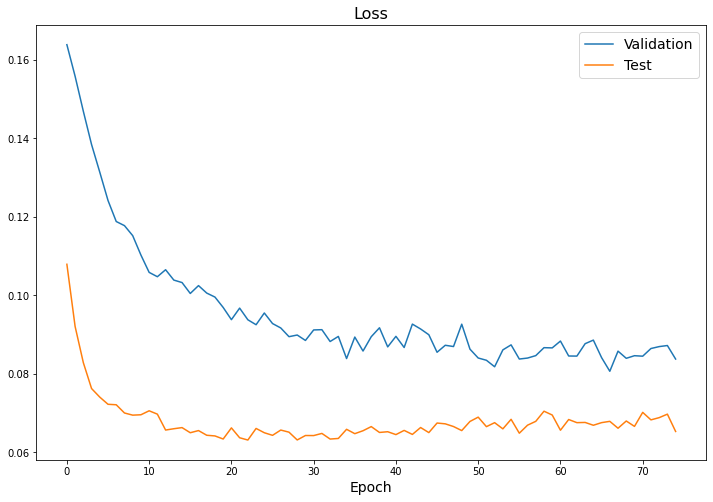

In [42]:
plt.figure(figsize=(12,8))
plt.plot(val_loss, label='Validation')
plt.plot(test_loss, label='Test')
plt.legend(fontsize=14)
plt.title('Loss', size=16)
plt.xlabel('Epoch', size=14)
plt.show()

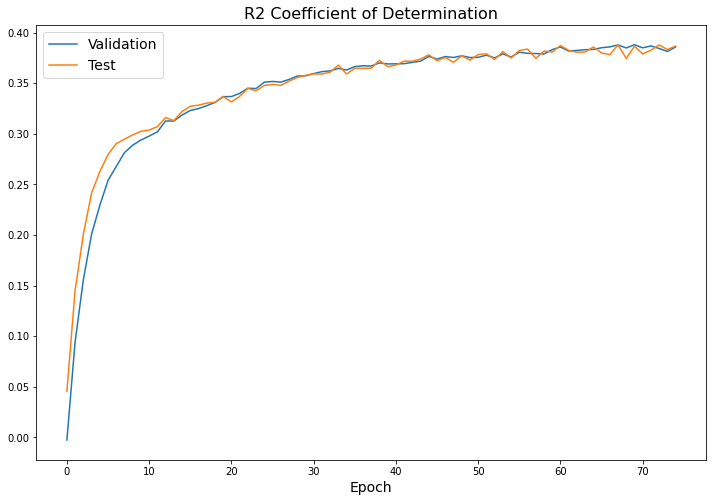

In [43]:
plt.figure(figsize=(12,8))
plt.plot(val_r2, label='Validation')
plt.plot(test_r2, label='Test')
plt.legend(fontsize=14)
plt.title('R2 Coefficient of Determination', size=16)
plt.xlabel('Epoch', size=14)
plt.show()